import data 

In [9]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/Personal_save/Python")

transactions = pd.read_csv("transactions.csv", na_values=["", "NA"])

display(transactions.head())

,t,success,mid,pmt,pg,sub_type,hr,bank
0,2,1,zivame,NB,PAYU,NaN,2020-02-14 06,NB_CITI
1,1,0,urbanclap,NB,PAYTM,NaN,2020-02-14 06,NB_SYNB
2,5,1,pharmeasytech,WALLET,AIRTELMONEY,REDIRECT_WALLET_DEBIT,2020-02-14 11,AIRTELMONEY
3,1,1,pharmeasytech,CARD,PAYU,NaN,2020-02-14 12,THE SATARA SAHAKARI BANK LTD MUMBAI
4,1,1,fanfight,CARD,RAZORPAY,NaN,2020-02-14 06,DCB


clean data 

In [10]:
#replace NA's with string
transactions.fillna("notprovided", inplace = True)

#change column names
transactions.columns = ["t", "s", "mid", "pmt", "pg", "subtype", "hr", "bank"]

compute the transaction failure rate for each unique hour within the data set and plot it 

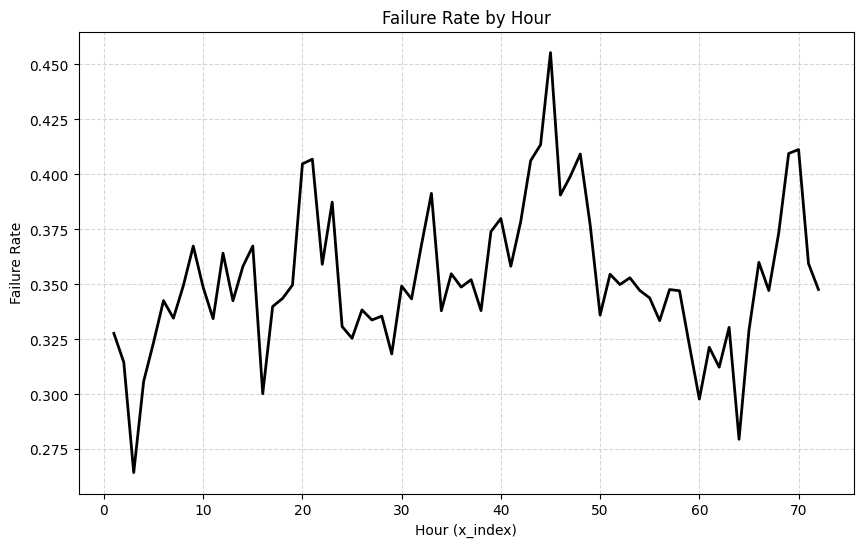

In [11]:
def plot_failure_rate(dataframe):
    unique_hours = sorted(dataframe['hr'].unique())

    t_by_hour = dataframe.groupby('hr')['t'].sum()
    s_by_hour = dataframe.groupby('hr')['s'].sum()

    failure_count = t_by_hour - s_by_hour
    failure_rate = failure_count / t_by_hour

    plot_data = pd.DataFrame({
        'hours': unique_hours,
        'failure_rate': failure_rate.values,
        'x_index': np.arange(1, len(unique_hours) + 1)
    })

    plt.figure(figsize=(10, 6))
    plt.plot(
        plot_data['x_index'],
        plot_data['failure_rate'],
        color='black',
        linewidth=2
    )
    plt.title("Failure Rate by Hour")
    plt.xlabel("Hour (x_index)")
    plt.ylabel("Failure Rate")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


plot_failure_rate(transactions)

append transaction failure rate and count of each row of data frame 

In [12]:
transactions['failures'] = transactions['t'] - transactions['s']
transactions['failure_rate'] = (transactions['t'] - transactions['s']) / transactions['t']

plotting the 2d distribution of failed transaction count and transaction failure rate 

In [13]:
import plotly.graph_objects as go
from scipy.stats import gaussian_kde as gaussian_kde

# Perform 2D Kernel Density Estimation (KDE)
x = transactions["t"]
y = transactions["failure_rate"]
kde = gaussian_kde([x, y])

# Create a grid for evaluation
x_grid = np.linspace(x.min(), x.max(), 50)
y_grid = np.linspace(y.min(), y.max(), 50)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()])).reshape(x_mesh.shape)

# Create 3D surface plot using Plotly
fig = go.Figure(data=[
    go.Surface(
        x=x_grid, 
        y=y_grid, 
        z=z, 
        colorscale="Viridis", 
        showscale=True
    )
])

# Add labels and title
fig.update_layout(
    title="3D KDE Surface Plot",
    scene=dict(
        xaxis_title="Failures",
        yaxis_title="Failure Rate",
        zaxis_title="Density"
    )
)

# Show the interactive plot
fig.show()


evaluating the Mohalanobis distances method

In [14]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import zscore

features = transactions[['t', 'failure_rate']]

center = features.mean().values # the .values argument produces a list of the column means 

cov_matrix = np.cov(features.T) #covance is calculated from paired observations 

inv_cov_matrix = np.linalg.inv(cov_matrix)
mahalanobis_distances = features.apply(
    lambda row: mahalanobis(row, center, inv_cov_matrix), axis=1
)

transactions["mahalanobis_score"] = mahalanobis_distances

transactions = transactions.sort_values(by="mahalanobis_score", ascending=False)

display(transactions.head(10))

,t,s,mid,pmt,pg,subtype,hr,bank,failures,failure_rate,mahalanobis_score
3871,3365,2524,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 15,UPI,841,0.249926,62.800060
4466,3340,2462,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 15,UPI,878,0.262874,62.331665
4169,1391,1086,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 02,UPI,305,0.219267,25.833265
4133,1357,918,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 14,UPI,439,0.323508,25.193931
3943,1258,767,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 14,UPI,491,0.390302,23.339856
4888,1230,1001,fanfight,WALLET,PAYTM,DIRECT_WALLET_DEBIT,2020-02-14 15,PAYTM,229,0.186179,22.819975
4969,1197,952,fanfight,WALLET,PAYTM,DIRECT_WALLET_DEBIT,2020-02-12 15,PAYTM,245,0.204678,22.201091
3837,1156,884,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 11,UPI,272,0.235294,21.431954
3865,1078,754,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-14 13,UPI,324,0.300557,19.969266
3909,1025,639,fanfight,UPI,PAYTM_UPI,UPI_PAY,2020-02-12 13,UPI,386,0.376585,18.976251


checking the failure rate plot of the categorical variables present in the outlier observations

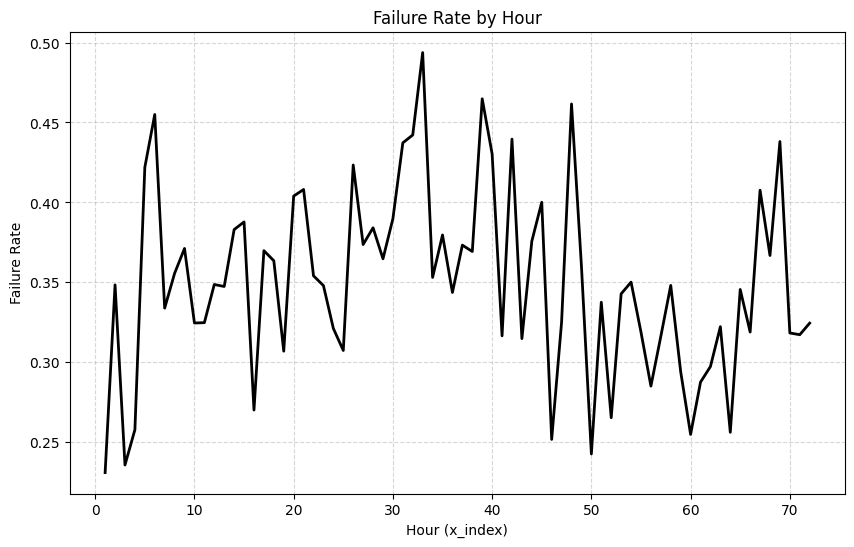

In [15]:
subset = transactions[
    (transactions['pmt'] == 'UPI') & 
    (transactions['pg'].isin(["PAYTM", "PAYTM_V2", "PAYTM_UPI"])) & 
    (transactions['subtype'] == 'UPI_PAY')
]

plot_failure_rate(subset)

ok so that's not the right combination, what about we plot all combiantions of the variables and see if we can sort through it to find what the problem is 

command r is run all
command enter is run the cell

In [16]:
import pandas as pd

# Extract unique values for payment methods and subtypes
payment_methods = transactions['pmt'].unique()
subtypes = transactions['subtype'].unique()
filter_values = ["PAYTM", "PAYTM_V2", "PAYTM_UPI"]

# Dictionary to store subsets
subset_dict = {}

# Generate subsets for each combination
for pmt in payment_methods:
    for st in subtypes:
        for fv in filter_values:
            subset_name = f"{pmt} | {fv} | {st}"  # Create a name for the combination
            subset_data = transactions[
                (transactions['pmt'] == pmt) &
                (transactions['subtype'] == st) &
                (transactions['pg'] == fv)
            ]
            subset_dict[subset_name] = subset_data

# Output the number of combinations produced
print(f"Number of combinations produced: {len(subset_dict)}")

Number of combinations produced: 75
